## All sky source density map for Gaia DR3

This notebook demonstrates the use of the combination of the Gaia archive and python tools to create an all-sky map source density of stars, calculated per Healpix pixel.

### Creating the map data with and ADQL query

```
SELECT
  gaia_healpix_index(5, source_id) AS healpix_5,
  COUNT(source_id) AS num_sources
FROM gaiadr3.gaia_source
GROUP BY healpix_5
ORDER BY healpix_5;
```
Note that this query returns the pixel number as float. So conversion with dtype='int' will be needed later.

This could have been handled in the query using: <br>
```CAST(gaia_healpix_index(5, source_id) AS INTEGER) AS healpix_5,```<br>
instead of:<br>
```gaia_healpix_index(5, source_id) AS healpix_5,```

Save to a file. In this example: SourceCountsHp5.csv

<Figure size 1000x500 with 0 Axes>

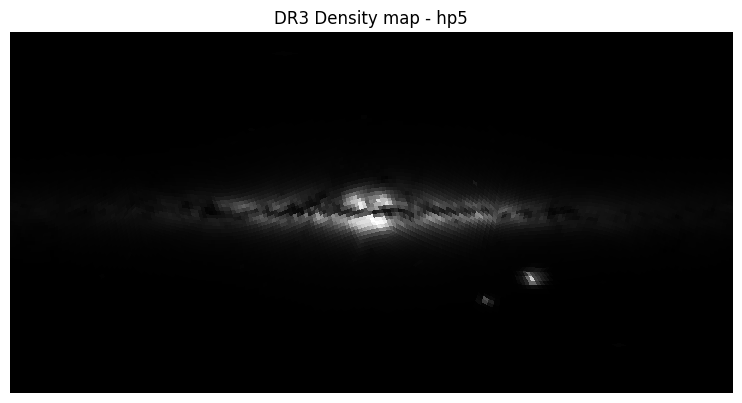

In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits

# Read the CSV File
filename = './data/SourceCountsHp5.csv'  
data = pd.read_csv(filename)

# Prepare HEALPix Data
healpix_indices = np.array(data['healpix_5'], dtype='int') # includes the conversion mentioned above

num_sources = np.array(data['num_sources'])

# HEALPix level 5 corresponds to nside = 2^5
nside = 2**5  # nside = 32 for HEALPix level 5
npix = hp.nside2npix(nside)  # Total number of pixels for nside = 32

# Initialize a HEALPix map with zeros
healpix_map = np.zeros(npix)

# Fill the map with source counts
healpix_map[healpix_indices] = num_sources

# Convert HEALPix Map to a Projection
fig = plt.figure(figsize=(10, 5))
img = hp.cartview(healpix_map, coord=['C','G'], return_projected_map=True, title='DR3 Density map - hp5', xsize=2048, cmap='gray', cbar=False, margins=None, nest=True, notext=True)



<Figure size 1000x500 with 0 Axes>

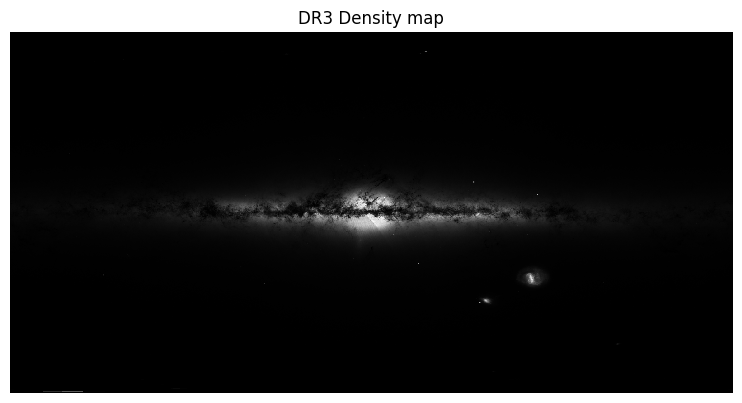

In [2]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Read the CSV File
filename = './data/SourceCountsHp9.csv'  
data = pd.read_csv(filename)

# Prepare HEALPix Data
healpix_indices = np.array(data['healpix_9'])  # Good query. Conversion not needed.
num_sources = np.array(data['num_sources'])

# HEALPix level 9 corresponds to nside = 2^9
nside = 2**9  # nside = 512 for HEALPix level 9
npix = hp.nside2npix(nside)  # Total number of pixels for nside = 512

# Initialize a HEALPix map with zeros
healpix_map = np.zeros(npix)

# Fill the map with source counts
healpix_map[healpix_indices] = num_sources

# Convert HEALPix Map to a Projection
fig = plt.figure(figsize=(10, 5))
img = hp.cartview(healpix_map, coord=['C','G'], return_projected_map=True, title='DR3 Density map', xsize=1600, cmap='gray', cbar=False, margins=None, nest=True, notext=True)



**Try hp.mollview for the mollweide projection!**

**The map was returned as a numpy array, which opens other possibilities with numpy:**

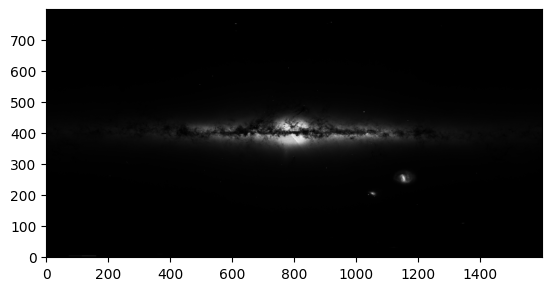

In [3]:
plt.imshow(img,cmap='gray',origin='lower')
plt.show()

**Or save directly to a png file**

In [4]:
plt.imsave('GaiaDR3_nsrc_map.png', np.flipud(img), cmap='gray')

**The healpix map can also be saved as a healpix fits file, that can be explored with other software (e.g. Aladin, ds9)**

In [5]:
hp.fitsfunc.write_map('GaiaDR3_nsrc_hp.fits', healpix_map, nest=True, overwrite=True)

setting the output map dtype to [dtype('float64')]


**And finally, you can also save the image as a regular fits with a WCS!**

In [6]:
img_filled = img.filled(0) # convert to regular array because fits write doesn't support masked arrays

# Create fits and load data
hdu = fits.PrimaryHDU(img_filled)  # Create a FITS HDU (Header/Data Unit)
hdulist = fits.HDUList([hdu])  # Create an HDU list to contain the HDU

# Create header and add WCS Keywords
header = hdu.header

header['CTYPE1'] = 'GLON-CAR'      # Galactic longitude in Cartesian projection
header['CRPIX1'] = 1024.0          # Reference pixel along the X-axis
header['CRVAL1'] = 0.0             # Galactic longitude at the reference pixel
header['CDELT1'] = -0.17578125     # Pixel size in degrees (negative for reverse axis)
header['CUNIT1'] = 'deg'           # Units of the X-axis

header['CTYPE2'] = 'GLAT-CAR'      # Galactic latitude in Cartesian projection
header['CRPIX2'] = 512.0           # Reference pixel along the Y-axis
header['CRVAL2'] = 0.0             # Galactic latitude at the reference pixel
header['CDELT2'] = 0.17578125      # Pixel size in degrees
header['CUNIT2'] = 'deg'           # Units of the Y-axis

header['LATPOLE'] = 90.0           # Latitude of the North Galactic Pole

# write to file
hdu.writeto('GaiaDR3_nsrc_map.fits', overwrite=True)  # Write the FITS file, overwrite if exists
